# Algorithm Practice
#### Goal is to use several simple sklearn algorithms to practice comparing:
- Model Performance
- ROC Curves
- Permutation Importance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_path = os.path.join("..","..","data","train.csv"); csv_path_test = os.path.join("..","..","data","test.csv")
train_data = pd.read_csv(csv_path); test_data = pd.read_csv(csv_path_test)

In [3]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## Are there any NA values? ANS: No

In [4]:
# Check for null values
train_data.isnull().values.any()

False

## What is the metadata? Can memory be reduced at all?

In [5]:
print(f"Datatype of target: {train_data.target.dtype}")
print(f"Datatype of variables: {train_data.var_0.dtype}")

Datatype of target: int64
Datatype of variables: float64


In [6]:
# Can modify dataype of these to int8 and float32 respectedly
train_data.target = train_data.target.astype(np.int8)
for col in train_data.iloc[:,2:].columns:
    train_data[col] = train_data[col].astype(np.float32)

print(f"New Datatype of target: {train_data.target.dtype}")
print(f"New Datatype of variables: {train_data.var_0.dtype}")

New Datatype of target: int8
New Datatype of variables: float32


In [7]:
# Print new memory usage:
mem_usg = train_data.memory_usage().sum() / 1024**2 
print("Memory usage is: ",mem_usg," MB")

Memory usage is:  154.30458068847656  MB


### Revisit the imbalance in Data

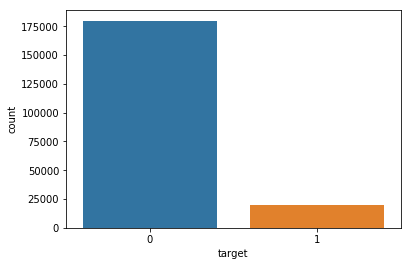

In [8]:
sns.countplot(x="target", data=train_data)
plt.show()

<hr>

## Algorithms to be used:
- LogisticRegression
- K Nearest Neighbors
- Decision Tree
- Random Forest
- SVM Linear
- SVM RBF
- SGDRegressor
- LightGBM (Seperate package... import lightgbm ias lgb)

In [9]:
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=["ID_code","target"])
y = train_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (140000, 200)
Test shape: (60000, 200)


### Start with LogisticRegression

In [11]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Model Creation
# C: Like in support vector machines, smaller values specify stronger regularization.
logmodel = LogisticRegression()

# fit the model to training data
logmodel.fit(X_train, y_train)

# Predict target values
predictions = logmodel.predict_proba(X_test)[:,1]

# Print the score of the fitted model
print(logmodel.score(X_test, y_test))
print()
print(classification_report(y_test, logmodel.predict(X_test)))

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9130666666666667
0.9130666666666667

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     53861
           1       0.70      0.26      0.38      6139

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.81      0.62      0.67     60000
weighted avg       0.90      0.91      0.89     60000

Wall time: 2min 44s


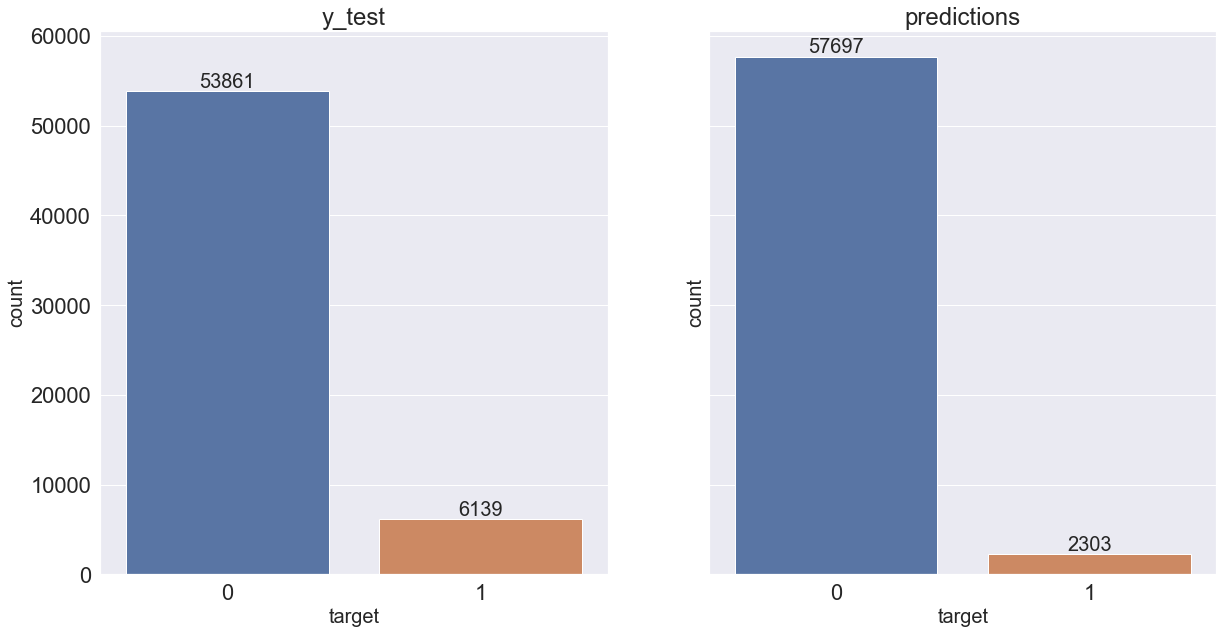

In [42]:
sns.set_style("darkgrid")
sns.set(font_scale = 2)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,10))
sns.countplot(x=y_test, ax=ax[0])
sns.countplot(x=logmodel.predict(X_test), ax=ax[1])
ax[0].set_title("y_test")
ax[1].set_title("predictions")

# Annotate the height above the plot
for a in ax:
    a.set_xlabel("target", fontsize=20)
    a.set_ylabel("count", fontsize=20)
    for p in a.patches:
        height = p.get_height()
        a.text(p.get_x()+p.get_width()/2., height + 400, height, ha="center", fontsize=20)

plt.show()

## Missing a lot of 1's

### Looks like the model performed decently despite the imbalance in data
Lets look at the ROC curve

In [13]:
# from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# # Create ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
# AUC = auc(fpr, tpr)

# print()
# print(f"Area Under the Curve Score: {AUC}")

# # Create Plot... Using seaborn plot takes longer to execute

# sns.set_style("darkgrid")

# fig, ax = plt.subplots(figsize=(20,10))
# sns.lineplot(x=fpr, y=tpr, ax=ax, color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=ax, color="red")
# ax.lines[1].set_linestyle("--")

# plt.show()

### The ROC Curve looks decent, but lets compare to the percision recall curve

In [14]:
# # Create PRC Curve
# p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))

# # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# # ROC Curve
# sns.lineplot(x=fpr, y=tpr, ax=axes[0], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=axes[0], color="red")
# axes[0].lines[1].set_linestyle("--")
# axes[0].set_ylim([-0.05, 1.05])
# axes[0].set_xlim([-0.05, 1.05])
# axes[0].set_title("ROC Curve")
# axes[0].set_xlabel("")
# axes[0].set_ylabel("")

# # PRC
# sns.lineplot(x=p, y=r, ax=axes[1], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[1,0], ax=axes[1], color="red")
# axes[1].lines[1].set_linestyle("--")
# axes[1].set_ylim([-0.05, 1.05])
# axes[1].set_xlim([-0.05, 1.05])
# axes[1].set_title("Percision Recall Curve")
# axes[1].set_xlabel("")
# axes[1].set_ylabel("")


In [15]:
# print(classification_report(y_test, logmodel.predict(X_test)))

## Observation notes:
- ROC Curve looks decent here because ROC curve does not punish for low False Positive Rate because there are so many negatives
- Precision is highly sensitive to false positives. PR curve should tend toward the top right for good models.

https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

## What if we used a StandardScaler()?

In [16]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train); X_test_scaled = scaler.transform(X_test)

### Put it all together:

In [17]:
# # Model Creation
# # C: Like in support vector machines, smaller values specify stronger regularization.
# logmodel = LogisticRegression(C=0.001, class_weight="balanced")

# # fit the model to training data
# logmodel.fit(X_train_scaled, y_train)

# # Predict target values
# predictions_scaled = logmodel.predict_proba(X_test_scaled)[:,1]

# # Print the score of the fitted model
# print(logmodel.score(X_test_scaled, y_test))

In [18]:
# # Create ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions_scaled.reshape(-1,1))
# AUC = auc(fpr, tpr)

# print()
# print(f"Area Under the Curve Score: {AUC}")

# # Create PRC Curve
# p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions_scaled.reshape(-1,1))

# # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# # ROC Curve
# sns.lineplot(x=fpr, y=tpr, ax=axes[0], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=axes[0], color="red")
# axes[0].lines[1].set_linestyle("--")
# axes[0].set_ylim([-0.05, 1.05])
# axes[0].set_xlim([-0.05, 1.05])
# axes[0].set_title("ROC Curve")
# axes[0].set_xlabel("")
# axes[0].set_ylabel("")

# # PRC
# sns.lineplot(x=p, y=r, ax=axes[1], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[1,0], ax=axes[1], color="red")
# axes[1].lines[1].set_linestyle("--")
# axes[1].set_ylim([-0.05, 1.05])
# axes[1].set_xlim([-0.05, 1.05])
# axes[1].set_title("Percision Recall Curve")
# axes[1].set_xlabel("")
# axes[1].set_ylabel("")

# plt.show()

In [19]:
# print(classification_report(y_test, logmodel.predict(X_test_scaled)))

### There's no noticable difference between scaling and not scaling!

<hr>

## Define Plotting function to produce comparison ROC Curve and PR Curve Charts! 

In [20]:
def ROC_PR_Curves(y_test, algo_dict):
    # Creates the ROC vs. PC Curve chart above after all the models have been calculated and stored in algo_dict
    # algo_dict ex: {"Logistic_Regression": log_predictions, "KNN": knn_predictions, ...}
    
    # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        
    for label, predictions in algo_dict.items():
        
        # Create ROC curve
        fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        AUC = np.round(auc(fpr, tpr), 4)
        sns.lineplot(x=fpr, y=tpr, ax=axes[0], label=f"{label} - AUC Score: {AUC}")

        # Create PR Curve
        p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        sns.lineplot(x=p, y=r, ax=axes[1], label=label)
    
    # ROC Curve Axes Parameters
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_title("ROC Curve")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")        
    
    # PR Curve Axes Parameters
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_title("Percision Recall Curve")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    # Display the Plot
    plt.show()
    
    return "Finished"

## Now that ROC_PR_Curve is available:
- Try all 8 algorithms
- Add results of predict_proba to algo_dict

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

X = train_data.drop(columns=["ID_code","target"])
y = train_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
# Define algo_dict
algo_dict = {}

### LogisticRegression

In [29]:
# Import model
from sklearn.linear_model import LogisticRegression

# Fit and calculate predictions to the model
logmodel = LogisticRegression(C=0.001, class_weight="balanced")
logmodel.fit(X_train, y_train)
predictions = logmodel.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["LogisticRegression"] = predictions

# print the score
print(logmodel.score(X_test, y_test))
print()
print(classification_report(y_test, logmodel.predict(X_test)))

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7808666666666667

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     53923
           1       0.28      0.77      0.41      6077

   micro avg       0.78      0.78      0.78     60000
   macro avg       0.63      0.77      0.64     60000
weighted avg       0.90      0.78      0.82     60000



### KNN - May try multiple k values. For now try 3.
#### Takes too long to run... will not be using this model

In [30]:
# # Import Model
# from sklearn.neighbors import KNeighborsClassifier

# # Fit and calculate predictions to the model
# neigh = KNeighborsClassifier(n_neighbors=3, weights="uniform")
# neigh.fit(X_train, y_train)
# predictions = neigh.predict_proba(X_test)[:,1]

# # Move predictions to algo_dict
# algo_dict["KNN_n=3"] = predictions

# # print the score
# print(neigh.score(X_test, y_test))
# print()
# print(classification_report(y_test, neigh.predict(X_test)))

### Decision Tree

In [31]:
# Import Model
from sklearn.tree import DecisionTreeClassifier

# Fit and calculate predictions to the model
dtree = DecisionTreeClassifier(class_weight="balanced")
dtree.fit(X_train, y_train)
predictions = dtree.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["DecisionTree"] = predictions

# print the score
print(dtree.score(X_test, y_test))
print()
print(classification_report(y_test, dtree.predict(X_test)))

0.8264833333333333

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     53923
           1       0.16      0.16      0.16      6077

   micro avg       0.83      0.83      0.83     60000
   macro avg       0.53      0.53      0.53     60000
weighted avg       0.83      0.83      0.83     60000



### Random Forest - for now lets use 15 trees.

In [32]:
# Import Model
from sklearn.ensemble import RandomForestClassifier

# Fit and calculate predictions to the model
N = 15
rforest = RandomForestClassifier(n_estimators=N, class_weight="balanced")
rforest.fit(X_train, y_train)
predictions = rforest.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict[f"RandomForect_N{str(N)}"] = predictions

# print the score
print(rforest.score(X_test, y_test))
print()
print(classification_report(y_test, rforest.predict(X_test)))

0.8986666666666666

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     53923
           1       0.38      0.00      0.00      6077

   micro avg       0.90      0.90      0.90     60000
   macro avg       0.64      0.50      0.47     60000
weighted avg       0.85      0.90      0.85     60000



### SVM Linear

In [33]:
# Import linearsvc and calibration to get probability
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Fit and calculate the model
svclinear = LinearSVC(C=0.0001, tol=1e-5, class_weight="balanced")
clf_svclinear = CalibratedClassifierCV(svclinear)
clf_svclinear.fit(X_train, y_train)
predictions = clf_svclinear.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["LinearSVC"] = predictions

# print the score
print(clf_svclinear.score(X_test, y_test))
print()
print(classification_report(y_test, clf_svclinear.predict(X_test)))

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9115666666666666

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     53923
           1       0.68      0.24      0.35      6077

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.80      0.61      0.65     60000
weighted avg       0.90      0.91      0.89     60000



### SVM RBF
Very slow (as predicted with large data sets)

In [34]:
# from sklearn.svm import SVC

# # Fit and calculate the model
# svc = SVC(C=0.001, kernel="rbf", gamma="auto", class_weight="balanced", probability=True, tol=1e-5)
# svc.fit(X_train, y_train)
# predictions = svc.predict_proba(X_test)


# algo_dict["SVM_RBF"] = predictions

# # print the score
# print(svc.score(X_test, y_test))
# print()
# print(classification_report(y_test, svc.predict(X_test)))

### SGDClassifier

In [35]:
from sklearn.linear_model import SGDClassifier

# Fit and calculate the model
sgd_clf = SGDClassifier(loss="log", class_weight="balanced", penalty="l2", tol=1e-5, max_iter=5)
sgd_clf.fit(X_train, y_train)
predictions = sgd_clf.predict_proba(X_test)[:,1]


algo_dict["SGDClassifier"] = predictions

# print the score
print(sgd_clf.score(X_test, y_test))
print()
print(classification_report(y_test, sgd_clf.predict(X_test)))

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.8694833333333334

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     53923
           1       0.39      0.50      0.44      6077

   micro avg       0.87      0.87      0.87     60000
   macro avg       0.66      0.71      0.68     60000
weighted avg       0.89      0.87      0.88     60000



### LightGBM
- for more complicated algorithms such as LightGBM, XGBoost, and CatBoost... There is a lot of parameter optimization required before the model is effective. These processes take up massive amounts of processing and can take several hours.
- for now, these parameters are already optimized

In [23]:
parameters = {
    'num_leaves': 8,
     'min_data_in_leaf': 42,
     'objective': 'binary',
     'max_depth': 16,
     'learning_rate': 0.0123,
     'boosting': 'gbdt',
     'bagging_freq': 5,
     'feature_fraction': 0.8201,
     'bagging_seed': 11,
     'reg_alpha': 1.728910519108444,
     'reg_lambda': 4.9847051755586085,
     'metric': 'auc',
     'verbosity': -1,
     'subsample': 0.81,
     'min_gain_to_split': 0.01077313523861969,
     'min_child_weight': 19.428902804238373,
     'num_threads': 4
}

In [27]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(**parameters, n_estimators = 2000, n_jobs = -1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.887454	valid_1's auc: 0.85851
[2000]	training's auc: 0.912422	valid_1's auc: 0.879136
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.912422	valid_1's auc: 0.879136


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=None,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [28]:
predictions = lgb_model.predict_proba(X_test)[:,1]

algo_dict["LGBMClassifier"] = predictions

# print the score
print(lgb_model.score(X_test, y_test))
print()
print(classification_report(y_test, lgb_model.predict(X_test)))

0.9102333333333333

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     53923
           1       0.89      0.13      0.23      6077

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.90      0.56      0.59     60000
weighted avg       0.91      0.91      0.88     60000



## Plot all models on a ROC Curve and PR Curve:

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


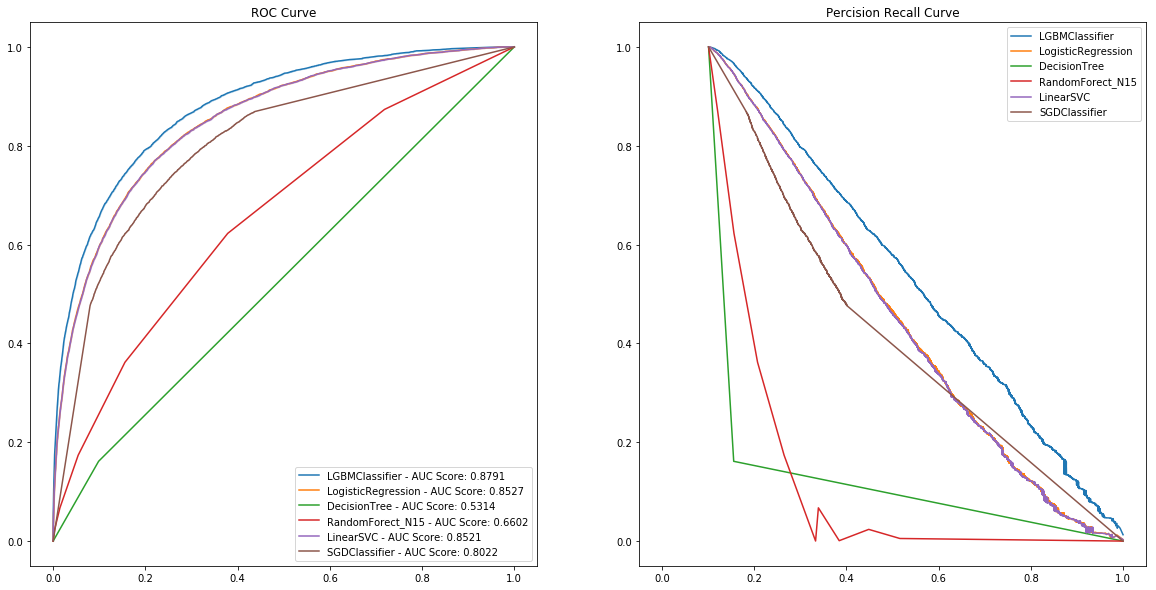

'Finished'

In [36]:
ROC_PR_Curves(y_test=y_test, algo_dict=algo_dict)